In [6]:
import numpy as np
import numpy
import torch, torchvision
from torch import nn, optim
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
import seaborn as sns
from sklearn.decomposition import PCA
from umap import UMAP
from package.umap.umap.parametric_umap import ParametricUMAP
import pickle
from sklearn import preprocessing
from umap.parametric_umap import load_ParametricUMAP
import os
import matplotlib
import joblib
sns.set()

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[2],'GPU')

# load fresh MNIST
mnist_train = torchvision.datasets.MNIST(root='./',
                                         train=True,
                                         download=True, 
                                         transform=None)
                                        #  transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),]))
x_train, y_train = mnist_train.data.float().numpy(), mnist_train.targets

mnist_test = torchvision.datasets.MNIST(root='./',
                                        train=False,
                                        download=True, 
                                        transform=None)
                                        # transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),]))
x_test, y_test = mnist_test.data.float().numpy(), mnist_test.targets
x_train2d = x_train.reshape((x_train.shape[0], -1))/255.
x_test2d = x_test.reshape((x_test.shape[0], -1))/255.

x2d = np.concatenate([x_train2d, x_test2d], axis=0)
y2d = np.concatenate([y_train, y_test], axis=0)

True
NVIDIA GeForce RTX 2080 Ti


In [7]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

# scatter plots
def get_scale(embd, max_length=0.5):
    # returns the smallest power of 10 that is smaller than max_length * the
    # spread in the x direction
    spreads = embd.max(0) - embd.min(0)
    spread = spreads.max()

    return 10 ** (int(np.log10(spread * max_length)))

def add_scale(ax, embd):
    """
    Adds a scale bar
    """
    scale = get_scale(embd)
    embd_w, embd_h = embd.max(0)- embd.min(0)
    height =  0.001 * embd_h

    scalebar = AnchoredSizeBar(ax.transData,
                               scale,
                               str(scale),
                               loc="lower center",
                               size_vertical=height,
                               #borderpad= 0.5,
                               sep=4,
                               frameon=False,
                               fontproperties={"size": 20})
    ax.add_artist(scalebar)
    return scalebar

def plot_hist(b,a,f,b1,a1,f1,title):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
    
    bins = 30
    ranges = (0,0.5)
    
    fig.suptitle(title)
    ax1.hist(b,bins=bins,range=ranges)
    ax1.axvline(b1,linewidth=2,color='r',label='final: '+str(round(b1,4)))
    ax1.set_title('Before')
    
    ax2.hist(a,bins=bins,range=ranges)
    ax2.axvline(a1,linewidth=2,color='r',label='final: '+str(round(a1,4)))
    ax2.set_title('After')
    
    ax3.hist(f,bins=bins,range=ranges)
    ax3.axvline(f1,linewidth=2,color='r',label='final: '+str(round(f1,4)))
    ax3.set_title('Final')
    
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax3.set_yscale('log')
    
    ax1.legend()
    ax2.legend()
    ax3.legend()
    
#     plt.show()
    plt.close()
    
def plot_hist_new(b,a,f,b1,a1,f1,title,q,w,e,q1,w1,e1):
    
    bins = 50
    ranges = (0,0.4)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
    
    fig.suptitle(title)
    ax1.hist(b,bins=bins,range=ranges,color='r',alpha=0.5)
    ax1.axvline(b1,linewidth=2,color='r',label='final 1/1: '+str(round(b1,4)),alpha=1)

    ax1.hist(q,bins=bins,range=ranges,color='g',alpha=0.5)
    ax1.axvline(q1,linewidth=2,color='darkgreen',linestyle='dashed',label='final: '+str(round(q1,4)),alpha=1)
    ax1.set_title('Before')
    
    ax2.hist(a,bins=bins,range=ranges,color='r',alpha=0.5)
    ax2.axvline(a1,linewidth=2,color='r',label='final 1/1: '+str(round(a1,4)),alpha=1)
    
    ax2.hist(w,bins=bins,range=ranges,color='g',alpha=0.5)
    ax2.axvline(w1,linewidth=2,color='darkgreen',linestyle='dashed',label='final: '+str(round(w1,4)),alpha=1)
    ax2.set_title('After')
    
    ax3.hist(f,bins=bins,range=ranges,color='r',alpha=0.5)
    ax3.axvline(f1,linewidth=2,color='r',label='final 1/1: '+str(round(f1,4)),alpha=1)
    
    ax3.hist(e,bins=bins,range=ranges,color='g',alpha=0.5)
    ax3.axvline(e1,linewidth=2,color='darkgreen',linestyle='dashed',label='final: '+str(round(e1,4)),alpha=1)
    ax3.set_title('Final')
    
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax3.set_yscale('log')
    
    ax1.legend()
    ax2.legend()
    ax3.legend()
    
#     plt.show()
    plt.close()

In [8]:
def calculate_mse(x_train,recon_train,true_loss):
    # true loss
    print('model loss: ',true_loss)
    # tensorflow
    mse_tf = tf.keras.losses.MeanSquaredError()
    mse_tf_val = (mse_tf(x_train, recon_train[:len(x_train)]).numpy())
    print('mse tensor: ',mse_tf_val)
    # numpy
    mse_numpy_val = np.mean(np.square(x_train - recon_train[:len(x_train)]),axis=1)
    # hist numpy
    counts1,bin_loc1,_ = plt.hist(mse_numpy_val,bins=1000)
    mse_hist_np = (counts1*bin_loc1[:-1]).sum()/len(x_train)
    plt.close()
    print('hist numpy: ',mse_hist_np)
    return(true_loss,mse_tf_val,mse_hist_np)

In [9]:
# # load embedding MNIST
# recon_embed_00 = pickle.load((open('./double_train_weight_umap3/1_28/umap_AE_run_0_[2, 0, 0, 0, 1, 28]final_.sav', 'rb')))
# recon_embed_10 = pickle.load((open('./double_train_weight_umap3/1_28/umap_AE_run_0_[2, 1, 0, 0, 1, 28]final_.sav', 'rb')))
# recon_embed_01 = pickle.load((open('./double_train_weight_umap3/1_28/umap_AE_run_0_[2, 0, 1, 0, 1, 28]final_.sav', 'rb')))
# recon_embed_11 = pickle.load((open('./double_train_weight_umap3/1_28/umap_AE_run_0_[2, 1, 1, 0, 1, 28]final_.sav', 'rb')))

# # load reconstructed MNIST final
# recon_train_00_f = pickle.load((open('./double_train_weight_umap3/1_28/umap_AE_run_0_[2, 0, 0, 0, 1, 28]final_reconstructions.sav', 'rb')))
# recon_train_10_f = pickle.load((open('./double_train_weight_umap3/1_28/umap_AE_run_0_[2, 1, 0, 0, 1, 28]final_reconstructions.sav', 'rb')))
# recon_train_01_f = pickle.load((open('./double_train_weight_umap3/1_28/umap_AE_run_0_[2, 0, 1, 0, 1, 28]final_reconstructions.sav', 'rb')))
# recon_train_11_f = pickle.load((open('./double_train_weight_umap3/1_28/umap_AE_run_0_[2, 1, 1, 0, 1, 28]final_reconstructions.sav', 'rb')))

# # Recon MSE final
# train_mse_00_f = ((x_train2d-recon_train_00_f[:60000])**2).mean(axis=1)
# train_mse_10_f = ((x_train2d-recon_train_10_f[:60000])**2).mean(axis=1)
# train_mse_01_f = ((x_train2d-recon_train_01_f[:60000])**2).mean(axis=1)
# train_mse_11_f = ((x_train2d-recon_train_11_f[:60000])**2).mean(axis=1)

# # load reconstructed MNIST before
# recon_train_00_b = pickle.load((open('./double_train_weight_umap3/1_28/umap_AE_run_0_[2, 0, 0, 0, 1, 28]before_reconstructions.sav', 'rb')))
# recon_train_10_b = pickle.load((open('./double_train_weight_umap3/1_28/umap_AE_run_0_[2, 1, 0, 0, 1, 28]before_reconstructions.sav', 'rb')))
# recon_train_01_b = pickle.load((open('./double_train_weight_umap3/1_28/umap_AE_run_0_[2, 0, 1, 0, 1, 28]before_reconstructions.sav', 'rb')))
# recon_train_11_b = pickle.load((open('./double_train_weight_umap3/1_28/umap_AE_run_0_[2, 1, 1, 0, 1, 28]before_reconstructions.sav', 'rb')))

# # Recon MSE before
# train_mse_00_b = ((x_train2d-recon_train_00_b[:60000])**2).mean(axis=1)
# train_mse_10_b = ((x_train2d-recon_train_10_b[:60000])**2).mean(axis=1)
# train_mse_01_b = ((x_train2d-recon_train_01_b[:60000])**2).mean(axis=1)
# train_mse_11_b = ((x_train2d-recon_train_11_b[:60000])**2).mean(axis=1)

# # load reconstructed MNIST after
# recon_train_00_a = pickle.load((open('./double_train_weight_umap3/1_28/umap_AE_run_0_[2, 0, 0, 0, 1, 28]after_reconstructions.sav', 'rb')))
# recon_train_10_a = pickle.load((open('./double_train_weight_umap3/1_28/umap_AE_run_0_[2, 1, 0, 0, 1, 28]after_reconstructions.sav', 'rb')))
# recon_train_01_a = pickle.load((open('./double_train_weight_umap3/1_28/umap_AE_run_0_[2, 0, 1, 0, 1, 28]after_reconstructions.sav', 'rb')))
# recon_train_11_a = pickle.load((open('./double_train_weight_umap3/1_28/umap_AE_run_0_[2, 1, 1, 0, 1, 28]after_reconstructions.sav', 'rb')))

# # Recon MSE after
# train_mse_00_a = ((x_train2d-recon_train_00_a[:60000])**2).mean(axis=1)
# train_mse_10_a = ((x_train2d-recon_train_10_a[:60000])**2).mean(axis=1)
# train_mse_01_a = ((x_train2d-recon_train_01_a[:60000])**2).mean(axis=1)
# train_mse_11_a = ((x_train2d-recon_train_11_a[:60000])**2).mean(axis=1)

# loss_history_00 = np.genfromtxt('./double_train_weight_umap3/1_28/umap_AE_run_0_[2, 0, 0, 0, 1, 28]history.csv', delimiter=',')
# loss_history_10 = np.genfromtxt('./double_train_weight_umap3/1_28/umap_AE_run_0_[2, 1, 0, 0, 1, 28]history.csv', delimiter=',')
# loss_history_01 = np.genfromtxt('./double_train_weight_umap3/1_28/umap_AE_run_0_[2, 0, 1, 0, 1, 28]history.csv', delimiter=',')
# loss_history_11 = np.genfromtxt('./double_train_weight_umap3/1_28/umap_AE_run_0_[2, 1, 1, 0, 1, 28]history.csv', delimiter=',')

# print('00')
# calculate_mse(x_train2d,recon_train_00_f,loss_history_00[1][-1])
# print('10')
# calculate_mse(x_train2d,recon_train_10_f,loss_history_10[1][-1])
# print('01')
# calculate_mse(x_train2d,recon_train_01_f,loss_history_01[1][-1])
# print('11')
# calculate_mse(x_train2d,recon_train_11_f,loss_history_11[1][-1])

In [10]:
# plot_hist(train_mse_00_b,train_mse_00_a,train_mse_00_f,loss_history_00[1][0],loss_history_00[1][1],loss_history_00[1][-1],
#           'MSE histogram for 0/0 setting (1st epoch)')

# plot_hist(train_mse_10_b,train_mse_10_a,train_mse_10_f,loss_history_10[1][0],loss_history_10[1][1],loss_history_10[1][-1],
#           'MSE histogram for 1/0 setting (1st epoch)')

# plot_hist(train_mse_01_b,train_mse_01_a,train_mse_01_f,loss_history_01[1][0],loss_history_01[1][1],loss_history_01[1][-1],
#           'MSE histogram for 0/1 setting (1st epoch)')

# plot_hist(train_mse_11_b,train_mse_11_a,train_mse_11_f,loss_history_11[1][0],loss_history_11[1][1],loss_history_11[1][-1],
#           'MSE histogram for 1/1 setting (1st epoch)')

In [11]:
# plot_hist_new(train_mse_11_b,train_mse_11_a,train_mse_11_f,loss_history_11[1][0],loss_history_11[1][1],loss_history_11[1][-1],
#           'MSE histogram for 1/1 vs 0/0 setting (1st epoch)',
#           train_mse_00_b,train_mse_00_a,train_mse_00_f,loss_history_00[1][0],loss_history_00[1][1],loss_history_00[1][-1])

# plot_hist_new(train_mse_11_b,train_mse_11_a,train_mse_11_f,loss_history_11[1][0],loss_history_11[1][1],loss_history_11[1][-1],
#           'MSE histogram for 1/1 vs 1/0 setting (1st epoch)',
#           train_mse_10_b,train_mse_10_a,train_mse_10_f,loss_history_10[1][0],loss_history_10[1][1],loss_history_10[1][-1])

# plot_hist_new(train_mse_11_b,train_mse_11_a,train_mse_11_f,loss_history_11[1][0],loss_history_11[1][1],loss_history_11[1][-1],
#           'MSE histogram for 1/1 vs 0/1 setting (1st epoch)',
#           train_mse_01_b,train_mse_01_a,train_mse_01_f,loss_history_01[1][0],loss_history_01[1][1],loss_history_01[1][-1])

In [12]:
# # load embedding MNIST
# recon_embed_00 = pickle.load((open('./double_train_weight_umap4/5_24/umap_AE_run_0_[2, 0, 0, 0, 5, 24]final_.sav', 'rb')))
# recon_embed_10 = pickle.load((open('./double_train_weight_umap4/5_24/umap_AE_run_0_[2, 1, 0, 0, 5, 24]final_.sav', 'rb')))
# recon_embed_01 = pickle.load((open('./double_train_weight_umap4/5_24/umap_AE_run_0_[2, 0, 1, 0, 5, 24]final_.sav', 'rb')))
# recon_embed_11 = pickle.load((open('./double_train_weight_umap4/5_24/umap_AE_run_0_[2, 1, 1, 0, 5, 24]final_.sav', 'rb')))

# # load reconstructed MNIST final
# recon_train_00_f = pickle.load((open('./double_train_weight_umap4/5_24/umap_AE_run_0_[2, 0, 0, 0, 5, 24]final_reconstructions.sav', 'rb')))
# recon_train_10_f = pickle.load((open('./double_train_weight_umap4/5_24/umap_AE_run_0_[2, 1, 0, 0, 5, 24]final_reconstructions.sav', 'rb')))
# recon_train_01_f = pickle.load((open('./double_train_weight_umap4/5_24/umap_AE_run_0_[2, 0, 1, 0, 5, 24]final_reconstructions.sav', 'rb')))
# recon_train_11_f = pickle.load((open('./double_train_weight_umap4/5_24/umap_AE_run_0_[2, 1, 1, 0, 5, 24]final_reconstructions.sav', 'rb')))

# # Recon MSE final
# train_mse_00_f = ((x_train2d-recon_train_00_f[:60000])**2).mean(axis=1)
# train_mse_10_f = ((x_train2d-recon_train_10_f[:60000])**2).mean(axis=1)
# train_mse_01_f = ((x_train2d-recon_train_01_f[:60000])**2).mean(axis=1)
# train_mse_11_f = ((x_train2d-recon_train_11_f[:60000])**2).mean(axis=1)

# # load reconstructed MNIST before
# recon_train_00_b = pickle.load((open('./double_train_weight_umap4/5_24/umap_AE_run_0_[2, 0, 0, 0, 5, 24]before_reconstructions.sav', 'rb')))
# recon_train_10_b = pickle.load((open('./double_train_weight_umap4/5_24/umap_AE_run_0_[2, 1, 0, 0, 5, 24]before_reconstructions.sav', 'rb')))
# recon_train_01_b = pickle.load((open('./double_train_weight_umap4/5_24/umap_AE_run_0_[2, 0, 1, 0, 5, 24]before_reconstructions.sav', 'rb')))
# recon_train_11_b = pickle.load((open('./double_train_weight_umap4/5_24/umap_AE_run_0_[2, 1, 1, 0, 5, 24]before_reconstructions.sav', 'rb')))

# # Recon MSE before
# train_mse_00_b = ((x_train2d-recon_train_00_b[:60000])**2).mean(axis=1)
# train_mse_10_b = ((x_train2d-recon_train_10_b[:60000])**2).mean(axis=1)
# train_mse_01_b = ((x_train2d-recon_train_01_b[:60000])**2).mean(axis=1)
# train_mse_11_b = ((x_train2d-recon_train_11_b[:60000])**2).mean(axis=1)

# # load reconstructed MNIST after
# recon_train_00_a = pickle.load((open('./double_train_weight_umap4/5_24/umap_AE_run_0_[2, 0, 0, 0, 5, 24]after_reconstructions.sav', 'rb')))
# recon_train_10_a = pickle.load((open('./double_train_weight_umap4/5_24/umap_AE_run_0_[2, 1, 0, 0, 5, 24]after_reconstructions.sav', 'rb')))
# recon_train_01_a = pickle.load((open('./double_train_weight_umap4/5_24/umap_AE_run_0_[2, 0, 1, 0, 5, 24]after_reconstructions.sav', 'rb')))
# recon_train_11_a = pickle.load((open('./double_train_weight_umap4/5_24/umap_AE_run_0_[2, 1, 1, 0, 5, 24]after_reconstructions.sav', 'rb')))

# # Recon MSE after
# train_mse_00_a = ((x_train2d-recon_train_00_a[:60000])**2).mean(axis=1)
# train_mse_10_a = ((x_train2d-recon_train_10_a[:60000])**2).mean(axis=1)
# train_mse_01_a = ((x_train2d-recon_train_01_a[:60000])**2).mean(axis=1)
# train_mse_11_a = ((x_train2d-recon_train_11_a[:60000])**2).mean(axis=1)

# loss_history_00 = np.genfromtxt('./double_train_weight_umap4/5_24/umap_AE_run_0_[2, 0, 0, 0, 5, 24]history.csv', delimiter=',')
# loss_history_10 = np.genfromtxt('./double_train_weight_umap4/5_24/umap_AE_run_0_[2, 1, 0, 0, 5, 24]history.csv', delimiter=',')
# loss_history_01 = np.genfromtxt('./double_train_weight_umap4/5_24/umap_AE_run_0_[2, 0, 1, 0, 5, 24]history.csv', delimiter=',')
# loss_history_11 = np.genfromtxt('./double_train_weight_umap4/5_24/umap_AE_run_0_[2, 1, 1, 0, 5, 24]history.csv', delimiter=',')

# print('00')
# calculate_mse(x_train2d,recon_train_00_f,loss_history_00[1][-1])
# print('10')
# calculate_mse(x_train2d,recon_train_10_f,loss_history_10[1][-1])
# print('01')
# calculate_mse(x_train2d,recon_train_01_f,loss_history_01[1][-1])
# print('11')
# calculate_mse(x_train2d,recon_train_11_f,loss_history_11[1][-1])

In [13]:
# plot_hist(train_mse_00_b,train_mse_00_a,train_mse_00_f,loss_history_00[1][0],loss_history_00[1][1],loss_history_00[1][-1],
#           'MSE histogram for 0/0 setting (5th epoch)')

# plot_hist(train_mse_10_b,train_mse_10_a,train_mse_10_f,loss_history_10[1][0],loss_history_10[1][1],loss_history_10[1][-1],
#           'MSE histogram for 1/0 setting (5th epoch)')

# plot_hist(train_mse_01_b,train_mse_01_a,train_mse_01_f,loss_history_01[1][0],loss_history_01[1][1],loss_history_01[1][-1],
#           'MSE histogram for 0/1 setting (5th epoch)')

# plot_hist(train_mse_11_b,train_mse_11_a,train_mse_11_f,loss_history_11[1][0],loss_history_11[1][1],loss_history_11[1][-1],
#           'MSE histogram for 1/1 setting (5th epoch)')

In [14]:
# plot_hist_new(train_mse_11_b,train_mse_11_a,train_mse_11_f,loss_history_11[1][0],loss_history_11[1][1],loss_history_11[1][-1],
#           'MSE histogram for 1/1 vs 0/0 setting (5th epoch)',
#           train_mse_00_b,train_mse_00_a,train_mse_00_f,loss_history_00[1][0],loss_history_00[1][1],loss_history_00[1][-1])

# plot_hist_new(train_mse_11_b,train_mse_11_a,train_mse_11_f,loss_history_11[1][0],loss_history_11[1][1],loss_history_11[1][-1],
#           'MSE histogram for 1/1 vs 1/0 setting (5th epoch)',
#           train_mse_10_b,train_mse_10_a,train_mse_10_f,loss_history_10[1][0],loss_history_10[1][1],loss_history_10[1][-1])

# plot_hist_new(train_mse_11_b,train_mse_11_a,train_mse_11_f,loss_history_11[1][0],loss_history_11[1][1],loss_history_11[1][-1],
#           'MSE histogram for 1/1 vs 0/1 setting (5th epoch)',
#           train_mse_01_b,train_mse_01_a,train_mse_01_f,loss_history_01[1][0],loss_history_01[1][1],loss_history_01[1][-1])

In [15]:
# # load embedding MNIST
# recon_embed_00 = pickle.load((open('./double_train_weight_umap4/10_19/umap_AE_run_0_[2, 0, 0, 0, 10, 19]final_.sav', 'rb')))
# recon_embed_10 = pickle.load((open('./double_train_weight_umap4/10_19/umap_AE_run_0_[2, 1, 0, 0, 10, 19]final_.sav', 'rb')))
# recon_embed_01 = pickle.load((open('./double_train_weight_umap4/10_19/umap_AE_run_0_[2, 0, 1, 0, 10, 19]final_.sav', 'rb')))
# recon_embed_11 = pickle.load((open('./double_train_weight_umap4/10_19/umap_AE_run_0_[2, 1, 1, 0, 10, 19]final_.sav', 'rb')))

# # load reconstructed MNIST final
# recon_train_00_f = pickle.load((open('./double_train_weight_umap4/10_19/umap_AE_run_0_[2, 0, 0, 0, 10, 19]final_reconstructions.sav', 'rb')))
# recon_train_10_f = pickle.load((open('./double_train_weight_umap4/10_19/umap_AE_run_0_[2, 1, 0, 0, 10, 19]final_reconstructions.sav', 'rb')))
# recon_train_01_f = pickle.load((open('./double_train_weight_umap4/10_19/umap_AE_run_0_[2, 0, 1, 0, 10, 19]final_reconstructions.sav', 'rb')))
# recon_train_11_f = pickle.load((open('./double_train_weight_umap4/10_19/umap_AE_run_0_[2, 1, 1, 0, 10, 19]final_reconstructions.sav', 'rb')))

# # Recon MSE final
# train_mse_00_f = ((x_train2d-recon_train_00_f[:60000])**2).mean(axis=1)
# train_mse_10_f = ((x_train2d-recon_train_10_f[:60000])**2).mean(axis=1)
# train_mse_01_f = ((x_train2d-recon_train_01_f[:60000])**2).mean(axis=1)
# train_mse_11_f = ((x_train2d-recon_train_11_f[:60000])**2).mean(axis=1)

# # load reconstructed MNIST before
# recon_train_00_b = pickle.load((open('./double_train_weight_umap4/10_19/umap_AE_run_0_[2, 0, 0, 0, 10, 19]before_reconstructions.sav', 'rb')))
# recon_train_10_b = pickle.load((open('./double_train_weight_umap4/10_19/umap_AE_run_0_[2, 1, 0, 0, 10, 19]before_reconstructions.sav', 'rb')))
# recon_train_01_b = pickle.load((open('./double_train_weight_umap4/10_19/umap_AE_run_0_[2, 0, 1, 0, 10, 19]before_reconstructions.sav', 'rb')))
# recon_train_11_b = pickle.load((open('./double_train_weight_umap4/10_19/umap_AE_run_0_[2, 1, 1, 0, 10, 19]before_reconstructions.sav', 'rb')))

# # Recon MSE before
# train_mse_00_b = ((x_train2d-recon_train_00_b[:60000])**2).mean(axis=1)
# train_mse_10_b = ((x_train2d-recon_train_10_b[:60000])**2).mean(axis=1)
# train_mse_01_b = ((x_train2d-recon_train_01_b[:60000])**2).mean(axis=1)
# train_mse_11_b = ((x_train2d-recon_train_11_b[:60000])**2).mean(axis=1)

# # load reconstructed MNIST after
# recon_train_00_a = pickle.load((open('./double_train_weight_umap4/10_19/umap_AE_run_0_[2, 0, 0, 0, 10, 19]after_reconstructions.sav', 'rb')))
# recon_train_10_a = pickle.load((open('./double_train_weight_umap4/10_19/umap_AE_run_0_[2, 1, 0, 0, 10, 19]after_reconstructions.sav', 'rb')))
# recon_train_01_a = pickle.load((open('./double_train_weight_umap4/10_19/umap_AE_run_0_[2, 0, 1, 0, 10, 19]after_reconstructions.sav', 'rb')))
# recon_train_11_a = pickle.load((open('./double_train_weight_umap4/10_19/umap_AE_run_0_[2, 1, 1, 0, 10, 19]after_reconstructions.sav', 'rb')))

# # Recon MSE after
# train_mse_00_a = ((x_train2d-recon_train_00_a[:60000])**2).mean(axis=1)
# train_mse_10_a = ((x_train2d-recon_train_10_a[:60000])**2).mean(axis=1)
# train_mse_01_a = ((x_train2d-recon_train_01_a[:60000])**2).mean(axis=1)
# train_mse_11_a = ((x_train2d-recon_train_11_a[:60000])**2).mean(axis=1)

# loss_history_00 = np.genfromtxt('./double_train_weight_umap4/10_19/umap_AE_run_0_[2, 0, 0, 0, 10, 19]history.csv', delimiter=',')
# loss_history_10 = np.genfromtxt('./double_train_weight_umap4/10_19/umap_AE_run_0_[2, 1, 0, 0, 10, 19]history.csv', delimiter=',')
# loss_history_01 = np.genfromtxt('./double_train_weight_umap4/10_19/umap_AE_run_0_[2, 0, 1, 0, 10, 19]history.csv', delimiter=',')
# loss_history_11 = np.genfromtxt('./double_train_weight_umap4/10_19/umap_AE_run_0_[2, 1, 1, 0, 10, 19]history.csv', delimiter=',')

# print('00')
# calculate_mse(x_train2d,recon_train_00_f,loss_history_00[1][-1])
# print('10')
# calculate_mse(x_train2d,recon_train_10_f,loss_history_10[1][-1])
# print('01')
# calculate_mse(x_train2d,recon_train_01_f,loss_history_01[1][-1])
# print('11')
# calculate_mse(x_train2d,recon_train_11_f,loss_history_11[1][-1])

In [16]:
# plot_hist(train_mse_00_b,train_mse_00_a,train_mse_00_f,loss_history_00[1][4],loss_history_00[1][5],loss_history_00[1][-1],
#           'MSE histogram for 0/0 setting (10th epoch)')

# plot_hist(train_mse_10_b,train_mse_10_a,train_mse_10_f,loss_history_10[1][4],loss_history_10[1][5],loss_history_10[1][-1],
#           'MSE histogram for 1/0 setting (10th epoch)')

# plot_hist(train_mse_01_b,train_mse_01_a,train_mse_01_f,loss_history_01[1][4],loss_history_01[1][5],loss_history_01[1][-1],
#           'MSE histogram for 0/1 setting (10th epoch)')

# plot_hist(train_mse_11_b,train_mse_11_a,train_mse_11_f,loss_history_11[1][4],loss_history_11[1][5],loss_history_11[1][-1],
#           'MSE histogram for 1/1 setting (10th epoch)')

In [17]:
# plot_hist_new(train_mse_11_b,train_mse_11_a,train_mse_11_f,loss_history_11[1][0],loss_history_11[1][1],loss_history_11[1][-1],
#           'MSE histogram for 1/1 vs 0/0 setting (10th epoch)',
#           train_mse_00_b,train_mse_00_a,train_mse_00_f,loss_history_00[1][0],loss_history_00[1][1],loss_history_00[1][-1])

# plot_hist_new(train_mse_11_b,train_mse_11_a,train_mse_11_f,loss_history_11[1][0],loss_history_11[1][1],loss_history_11[1][-1],
#           'MSE histogram for 1/1 vs 1/0 setting (10th epoch)',
#           train_mse_10_b,train_mse_10_a,train_mse_10_f,loss_history_10[1][0],loss_history_10[1][1],loss_history_10[1][-1])

# plot_hist_new(train_mse_11_b,train_mse_11_a,train_mse_11_f,loss_history_11[1][0],loss_history_11[1][1],loss_history_11[1][-1],
#           'MSE histogram for 1/1 vs 0/1 setting (10th epoch)',
#           train_mse_01_b,train_mse_01_a,train_mse_01_f,loss_history_01[1][0],loss_history_01[1][1],loss_history_01[1][-1])

In [29]:
model_loss_1 = np.genfromtxt('./testing123/0_20/umap_AE_run_0_[2, 1, 1, 0, 0, 20]model_loss.csv', delimiter=',')
model_mse_1 = np.genfromtxt('./testing123/0_20/umap_AE_run_0_[2, 1, 1, 0, 0, 20]model_mse.csv', delimiter=',')
model_umap_1 = np.genfromtxt('./testing123/0_20/umap_AE_run_0_[2, 1, 1, 0, 0, 20]model_umap.csv', delimiter=',')
numpy_loss_1 = np.genfromtxt('./testing123/0_20/umap_AE_run_0_[2, 1, 1, 0, 0, 20]numpy_loss.csv', delimiter=',')
tensorflow_loss_1 = np.genfromtxt('./testing123/0_20/umap_AE_run_0_[2, 1, 1, 0, 0, 20]tensorflow_loss.csv', delimiter=',')

Text(0.5, 1.0, 'parametric loss weight 1 and umap loss weight 1')

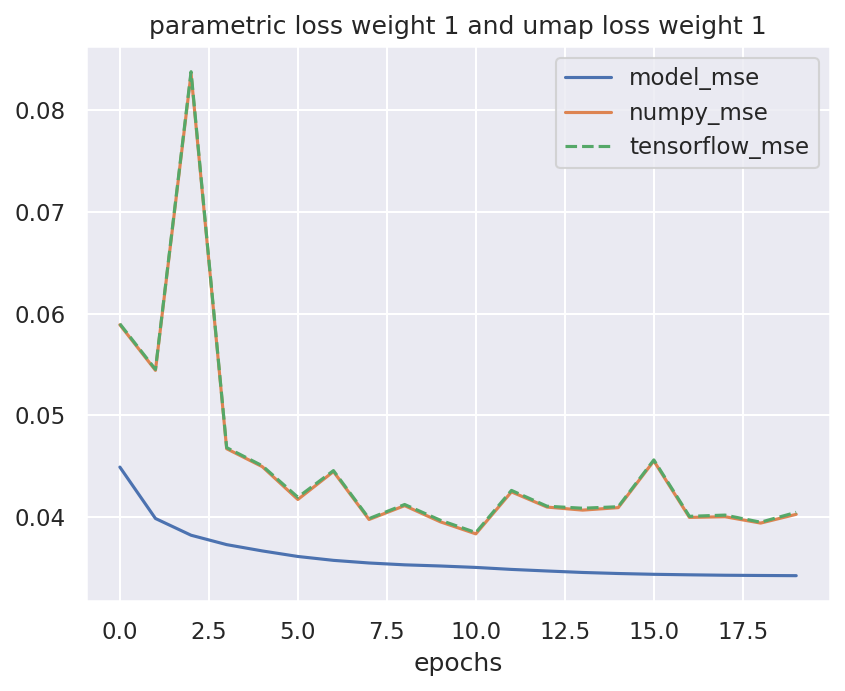

In [33]:
plt.figure(dpi=150)
# plt.plot(model_loss_1,label='model_loss')
plt.plot(model_mse_1,label='model_mse')
# plt.plot(model_umap_1,label='model_umap')
plt.plot(numpy_loss_1,label='numpy_mse')
plt.plot(tensorflow_loss_1,label='tensorflow_mse',linestyle='dashed')
plt.legend()
plt.xlabel('epochs')
plt.title('parametric loss weight 1 and umap loss weight 1')

In [31]:
model_loss_0 = np.genfromtxt('./testing123/0_20/umap_AE_run_0_[2, 0, 0, 0, 0, 20]model_loss.csv', delimiter=',')
model_mse_0 = np.genfromtxt('./testing123/0_20/umap_AE_run_0_[2, 0, 0, 0, 0, 20]model_mse.csv', delimiter=',')
model_umap_0 = np.genfromtxt('./testing123/0_20/umap_AE_run_0_[2, 0, 0, 0, 0, 20]model_umap.csv', delimiter=',')
numpy_loss_0 = np.genfromtxt('./testing123/0_20/umap_AE_run_0_[2, 0, 0, 0, 0, 20]numpy_loss.csv', delimiter=',')
tensorflow_loss_0 = np.genfromtxt('./testing123/0_20/umap_AE_run_0_[2, 0, 0, 0, 0, 20]tensorflow_loss.csv', delimiter=',')

Text(0.5, 1.0, 'parametric loss weight 1 and umap loss weight 0')

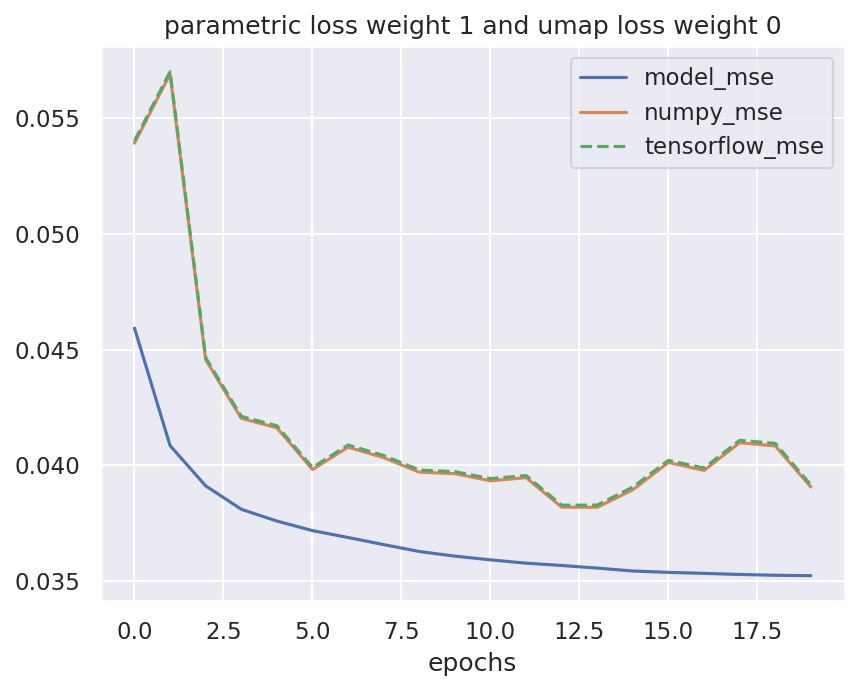

In [36]:
plt.figure(dpi=150)
# plt.plot(model_loss_0,label='model_loss')
plt.plot(model_mse_0,label='model_mse')
# plt.plot(model_umap_0,label='model_umap')
plt.plot(numpy_loss_0,label='numpy_mse')
plt.plot(tensorflow_loss_0,label='tensorflow_mse',linestyle='dashed')
plt.legend()
plt.xlabel('epochs')
plt.title('parametric loss weight 1 and umap loss weight 0')